# TDS Why you should try Bayesian AB Testing <a id="two"></a>
https://towardsdatascience.com/why-you-should-try-the-bayesian-approach-of-a-b-testing-38b8079ea33a

In [ ]:
import pandas as pd
import pymc3 as pm
import numpy as np
import theano.tensor as tt
from IPython.core.pylabtools import figsize
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [ ]:
df = pd.read_csv('C:\\Users\\wallj\\DS_Projects\\Machine-Learning-Examples\\cookie_cats.csv')

In [ ]:
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


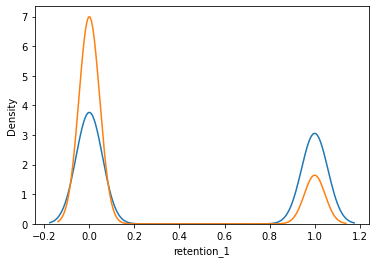

In [ ]:
site_A = df[df['version'] == 'gate_30']
sns.kdeplot(site_A['retention_1']);
sns.kdeplot(site_A['retention_7']);

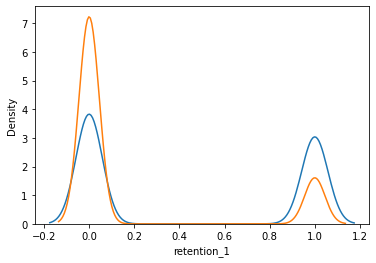

In [ ]:
site_B = df[df['version'] == 'gate_40']
sns.kdeplot(site_B['retention_1']);
sns.kdeplot(site_B['retention_7']);

In [ ]:
df.groupby('version').count() # group by the version to see the sample size of each variant

,userid,sum_gamerounds,retention_1,retention_7
version,,,,
gate_30,44700,44700,44700,44700
gate_40,45489,45489,45489,45489


In [ ]:
N_A = 44700
N_B = 45489

observations_A = df[df['version'] == 'gate_30']['retention_1'].values.astype(int)
observations_B = df[df['version'] == 'gate_40']['retention_1'].values.astype(int)

print('The number of users retained after 1 day in variant A:', observations_A.sum())
print('The number of users retained after 1 day in variant B:', observations_B.sum())

The number of users retained after 1 day in variant A: 20034
The number of users retained after 1 day in variant B: 20119


In [ ]:
df.groupby('version').mean()[['retention_1','retention_7']]

,retention_1,retention_7
version,,
gate_30,0.448188,0.190201
gate_40,0.442283,0.182000


In [ ]:
#these two quantities are unknown to us. And you can assume the values
true_p_A = 0.45
true_p_B = 0.40
# Set up the pymc3 model. Assume Beta priors for p_A and p_B.
with pm.Model() as model:
    p_A = pm.Beta("p_A", 11, 14) #11 successes and 14 failures
    p_B = pm.Beta("p_B", 11, 14)
    
    # Define the deterministic delta function. This is our unknown of interest.
    delta = pm.Deterministic("delta", p_A - p_B)

    
    # Set of observations, in this case we have two observation datasets (the two variants).
    # this is the likelihood function where we use the prior distribution as our parameter in the likelihood function
    obs_A = pm.Bernoulli("obs_A", p_A, observed=observations_A)
    obs_B = pm.Bernoulli("obs_B", p_B, observed=observations_B)

    
    step = pm.Metropolis()
    trace = pm.sample(20000, step=step) # sample 20000 iterations and store the paths of all our variables, or "traces"
    burned_trace=trace[1000:] # discard the first 1000 iterations

<ipython-input-14-701f88cf8607>:20: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(20000, step=step) # sample 20000 iterations and store the paths of all our variables, or "traces"
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [p_B]
>Metropolis: [p_A]


Sampling 4 chains for 1_000 tune and 1_180 draw iterations (4_000 + 4_720 draws total) took 1728 seconds.
